In [1]:
import numpy as np
import matplotlib.pyplot as plt
import coffea.util as util
import coffea.hist as hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from mySchema import MySchema
import uproot
import awkward as ak

/Users/sambt/anaconda3/envs/coffea/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Part 1 : Basic file I/O

Here, we'll just load in a root file as a coffea object using the "base schema". It will just load all the branches in a "normal" way, and we'll have to access them by their full names

In [2]:
# Loading in the signal sample
fname = "samples/sig_m108-dm36-ct1.root"
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=BaseSchema,
    treepath='ntuples/outT'
).events()

If we look at the branches, we see that they just correspond to the names of the TTree branches

In [3]:
print(events.fields[:20])

['trigFired', 'trigFired16', 'trigFired17', 'trigFired18', 'eventNum', 'lumiSec', 'runNum', 'METFiltersFailBits', 'nElectron', 'Electron_pt', 'Electron_eta', 'Electron_etaErr', 'Electron_phi', 'Electron_phiErr', 'Electron_angRes', 'Electron_energy', 'Electron_px', 'Electron_py', 'Electron_pz', 'Electron_vxy']


In [4]:
events.Electron_pt

<Array [[21.2], [7.28, 45.2, ... [18.8, 7]] type='25678 * var * float32[paramete...'>

Accessing the branch names this way is a bit cumbersome, so we can use the [NanoAODSchema](https://coffeateam.github.io/coffea/api/coffea.nanoevents.NanoAODSchema.html#coffea.nanoevents.NanoAODSchema), which makes accessing objects/sub-objects simpler. For this to work properly, you have to name your branches using the NanoAOD naming convention (outlined in the link above). When I was creating the ntuples for this analysis, there was a small typo in one branch name that broke things, so we'll use my custom `MySchema` that I imported above. It's just a carbon copy of the `NanoAODSchema` to which I added a couple lines of code to read the typo'd branch name correctly. I fixed this bug in the ntuplizer, so future versions of the ntuples can just use the `NanoAODSchema`

In [5]:
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=MySchema,
    treepath='ntuples/outT'
).events()

In [6]:
print(events.fields[:20])

['GenEleMatchC', 'trigFired17', 'PFMET', 'eventNum', 'Electron', 'lumiSec', 'GenPosMatches', 'trigFired18', 'PuppiMETPF', 'LRvtx', 'RRvtx', 'PFJet', 'nPFJetAll', 'EleCand', 'EECand', 'ootPhoton', 'genWgt', 'METFiltersFailBits', 'GenEleMatches', 'HEM']


Now, our branches are categorized nicely into physics objects (electrons, jets, MET, etc.). We can access products very easily:

In [7]:
eles = events.Electron
print(eles.fields)

['pt', 'eta', 'etaErr', 'phi', 'phiErr', 'angRes', 'energy', 'px', 'py', 'pz', 'vxy', 'vz', 'dxy', 'dxyErr', 'dz', 'dzErr', 'trkChi2', 'trkIso', 'trkRelIso', 'numTrackerHits', 'numPixHits', 'numStripHits', 'charge', 'trkProb']


# Part 2 : Basic columnar operations

The "columnar" part of columnar data analysis essentially means that we'll treat our TTree like a pandas dataframe. Each entry (branch) is a "jagged array" handled by the [Awkward Array](https://awkward-array.readthedocs.io/en/latest/) python package (developed by HEP folks!). You can manipulate these arrays much like you'd manipulate a numpy array, with some restrictions.

In [8]:
ele_pt = events.Electron.pt
print(ele_pt[:10])
print(ele_pt[:10] > 15)

[[21.2], [7.28, 45.2, 2.54, 3.55, 3.33], [21.8, ... [27.7], [38.1, 11.7], [5.46], []]
[[True], [False, True, False, False, False], ... [True, False], [False], []]


So, there's 1 electron with $p_T = 21.2$ GeV in event 1, 5 electrons in event 2, etc. The 10th event has no electrons, as shown by the empty array entry. If we want to cut on $p_T > 15$ GeV, we can do it using the boolean array `ele_pt > 15`.

In [9]:
ele_cut = ele_pt[ele_pt > 15]
print(ele_cut[:10])

[[21.2], [45.2], [21.8], [], [18.9, 22.1], [], [27.7], [38.1], [], []]


We don't have to cut on *just* the $p_T$ entry, though! We can cut the `events.Electron` array using the $p_T > 15$ mask, then access the other electron properties ($\eta$, $\phi$, etc.) corresponding to electrons with $p_T > 15$ GeV

In [10]:
eles = events.Electron
eles_cut = eles[eles.pt > 15]
print(eles_cut[:10])
print(eles_cut.eta[:10])

[[Electron], [Electron], [Electron], [], ... [], [Electron], [Electron], [], []]
[[-2.17], [0.43], [1.57], [], [-1.57, -0.847], [], [1.41], [-1.78], [], []]


The "electron" entries just mean that each event has an array of "electron" objects, with corresponding sub-objects like $p_T$ etc. The coffea `NanoAODSchema` has lots of built-in TTree parsing rules for converting things like electrons, photons, jets into more sophisticated objects that you can do math with (e.g. summing the Lorentz four-vectors of two objects), but that stuff is optimized for people who are *actually working with NanoAOD*. We're working with custom ntuples whose branch names are NanoADO-like, so it's probably best not to try using the coffea builtins unless you've checked that they'll work properly!

We can also apply event-level cuts to the `events` object. For example, we want to select events that have at least 1 electron with $p_T > 15$ GeV. 

In [11]:
# printing electron level pT > 15 mask
pt_mask = eles.pt > 15
print(pt_mask[:10])

# using ak.any(mask,axis=1) to tell if there's at least one electron with pT > 15 in each event
# ak.any(...,axis=1) will check if there's at least one True entry in the event-level (inner) array of booleans
event_mask = ak.any(pt_mask,axis=1)
print(event_mask[:10])

[[True], [False, True, False, False, False], ... [True, False], [False], []]
[True, True, True, False, True, False, True, True, False, False]


You can see that the 10th event -- which has no electrons -- gets you a `False` entry in the event-level mask. This is good, since we don't want to keep that! **In my experience, however, coffea/akward doesn't always handle empty event-level arrays in the way you want it to! If you're handling a branch where it's possible for an event-level array to be empty somewhere, make sure it's behaving sensibly!**

Now, we can apply the cut and see how many events we keep:

In [12]:
# initial number of events
print(len(events))

# number of events with >=1 electron with pT > 15
print(len(events[event_mask]))

25678
16842


# Part 3 : Filling histograms

Coffea histograms are nothing special, but have a few interesting quirks. In this example we'll build a histogram of the leading jet $p_T$ in each event using two different samples: a QCD background sample and a signal sample. We'll add two axes to our histogram: one `Bin` axis for the jet $p_T$, and one `Cat` axis to index the sample (signal/bkg) that each $p_T$ spectrum comes from

In [13]:
# load in the signal/background files
sig = NanoEventsFactory.from_root("samples/sig_m108-dm36-ct1.root",schemaclass=MySchema,treepath='ntuples/outT').events()
bkg = NanoEventsFactory.from_root("samples/bkg_QCDHT500to700.root",schemaclass=MySchema,treepath='ntuples/outT').events()

In [14]:
# Build the histogram
pt_hist = hist.Hist(
    "Events",
    hist.Bin("pt","Leading Jet $p_T$ [GeV]",100,0,1000),
    hist.Cat("sample","Sample Type")
)

To access the leading jet pT, we might naively just use `events.PFJet.pt[:,0]` -- but this will cause an error! If an event has no jets in it, the `PFJET.pt` entry for that event will be `[]`, and awkard array will give you an "index out of bounds" error. We first need to apply a cut to require events to have $\geq 1$ jets. Once this cut is applied (or if you applied it in preselection), the indexing of element 0 will work just fine

In [15]:
# require at least 1 jet
sig = sig[ak.count(sig.PFJet.pt,axis=1) > 0]
bkg = bkg[ak.count(bkg.PFJet.pt,axis=1) > 0]

Filling the histogram is easy, but you need to make sure the arrays you pass it are *flat* (i.e. no nested arrays). Since we're grabbing the first jet in each event with `[:,0]`, this will give us a flat (non-nested) array. If -- for some odd reason -- you wanted to put the $p_T$s of *all* the jets into the histogram, you have to use `ak.flatten(events.PFJet.pt)` to fill the histogram.

In [16]:
pt_hist.fill(
    pt=sig.PFJet.pt[:,0],
    sample="Signal"
)

pt_hist.fill(
    pt = bkg.PFJet.pt[:,0],
    sample="Background"
)

Now, we can have a look at our $p_T$ spectra. We'll plot normalized spectra (different numEvents in each sample), and use `coffea.hist.plot1d`'s "overlay" feature to overlay the `sample` axis in the 1D plot (i.e. plot signal & bkg with each other)

<AxesSubplot:xlabel='Leading Jet $p_T$ [GeV]', ylabel='Events'>

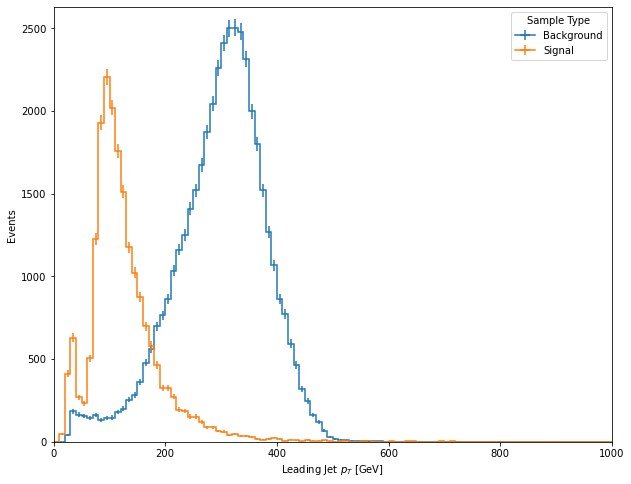

In [17]:
plt.figure(figsize=(10,8))
hist.plot1d(pt_hist,overlay="sample")

These QCD events are in the $H_T \in [500,700]$ GeV bin, which is why the $p_T$ spectrum looks odd!